# **Modeling Mood from Counterfactual Outcomes as Integrated Advantages**

Final Project for A Fink 12/12/2022

### **Abstract** 
Computational models of mood seek to describe the impact of reward computations on human mood fluctuations. These models have repeatedly shown that one's mood state is altered by reward outcomes, reward prediction errors, and expected value of reward options in monetary gambling tasks. [3] Current mood models fail to account for counterfactual outcomes as a model-based reward signal that impacts mood. Counterfactuals are defined as the difference in reward obtained and reward that *could have* been obtained, had one made a different decision. In the present study, counterfactuals are calcuated as a policy-weighted reward difference. [1] I aim to investigate the relationship between counterfactual outcomes and mood responses. I hypothesize that mood rating will change as a function of the integrated advantage of counterfactual outcomes.



### **Introduction**

Understanding human mood responses to external stimuli is a central goal of computational psychiatry. Mood disorders, like major depressive disorder, are debilitating and life-threatening. Without a clear understanding of the relationship between mood fluctuations and reward computations in humans, we cannot effectively treat patients with mood disorders. 

I hypothesize that model-based reward computations heaviliy impact mood. Current computational models of mood include only model-free reward computations, like reward prediction errors, to account for mood fluctuations during decision making. By not accounting for model-based reward signals in computational models, these computational theories about mood state are lacking. Such models have failed to find differences in encoding model-free reward computations in patients with major depressive disorder, showing that these models are missing a key component mood. Counterfactual signals are a model-based signal often thought of as regret. These signals are known to effect decision-making behavior and in patients with depression, regret is heightened and contributes to symptoms of rumination. I hypothesize that models using model-based counterfactual signals will out perform models with solely model-free reward computations. 

Rather than calculating counterfactual signals as the raw difference in outcome - possible outcome, I hypothesize that counterfactual signals are computed as a policy-weighted reward difference. The PWRD seeks to model mood as an Integrated Advantage [1], where mood is influenced by an agent's appraisal of their actions. Measuring counterfactual signals as a PWRD allows models to account for an agent's individual preference for loss, risk, and gamble choice. 

Subjects will play the Subjective Wellbeing task. The SWB is a 150 trial gambling task where participants are offered a safe bet reward option or a gamble reward option with a 50% chance of a greater or worse outcome than the safe bet option. The outcome of the unchosen option is shown to subjects after they make their choice, creating a counterfactual reward signal. Every 3 trials subjects rate their current happiness rating. 

I hypothesize that the policy-weighted reward difference model will best predict subject's mood ratings throughout the subjective-wellbeing task. 



### **Methods** Part One: Estimating Gamble Probabilities using Prospect Theory Model

Prior to calculating counterfactual outcomes, patient-specific gamble preferences must be estimated. Using a 3-parameter Prospect Theory Model, I estimated a patient's loss aversion, risk aversion, and gamble choice probability. First, the subjective utility for the safe and gamble choice was calculated for every trial, with different calculations for different trial types (mix,loss,gain). Then, the gamble choice probability was estimated using the difference in subjective utility of gamble and safe choices in a softmax function. Loss aversion, risk aversion, and gamble choice probability were estimated using Maximum Likelihood Estimation.[2]

The gamble choice probability, mu, was then used to calculate policy weighted reward differences in actual and counterfactual outcomes for every trial. [1] See Part Two below. 

In [ ]:
#load dependencies

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy import stats    
import math   

In [ ]:
#preprocessing data
#subjects = pd.read_excel('/content/SWB_subjects.xlsx', sheet_name = 'Usable Subjects', usecols = 'A')
df = pd.read_csv('/content/MS017_task_data')
df['Gamble.Choice'] = df["Gamble.Choice"].replace({"gamble":1,"safe":0}) #gamble choice must be numerically coded
rating = pd.read_csv('/content/MS017_rate_data')
rating = rating['zscore_mood']

In [ ]:
##### Defining Prospect Theory Function ######

#Estimating 3 free parameters: 
  #- lambda: loss aversion parameter
  #- rho: risk aversion parameter
  #- mu: inverse temperature

#Calculate Subjective Utility Differences
 #mix trials
  #util_diff = 0.5*high_bet^risk_aversion + 0.5*loss_aversion*low_bet^risk_aversion
 #loss trials
  #util_diff = (0.5*loss_aversion*high_bet + 0.5*loss_aversion*low_bet) - loss_aversion*safe_bet
 #gain trials
  #util_diff = 0.5*high_bet^risk_aversion - safe_bet^risk_aversion


#Calculate Probability of Choosing the Gamble 
#p_accept = 1/(1+math.e^-mu*util_diff) #softmax equation


def ProspectTheory(params,df):
    """
    Function estimates the negative log likelihood of param estimates
    
    Args:
    df (single subject df with trialtype, offers(safe,low,high), and gamble choice)
    params (list of initial values for loss_aversion, risk_aversion, mu)

    """
    probs = []
    loss_aversion = params[0]
    risk_aversion = params[1]
    mu = params[2]

    for i in range(0,150):
      trial_type = df['TrialType'][i]
      high_bet = df['High.Bet'][i]
      low_bet = df['Low.Bet'][i]
      safe_bet = df['Safe.Bet'][i]
      choice = df['Gamble.Choice'][i]

      #calculate difference in subjective utilities for trial 
      
      if trial_type == 'mix':
        util_diff = (0.5*(high_bet**risk_aversion)) + (0.5*((loss_aversion*(low_bet**risk_aversion))) #might not need negative in front of low
      elif trial_type == 'loss':
        util_diff = (0.5*(loss_aversion*high_bet)) + (0.5*(loss_aversion*(low_bet)) - (loss_aversion*safe_bet)
      else: #gain
        util_diff = (0.5*(high_bet**risk_aversion)) - (safe_bet**risk_aversion)

      #calculate probability of gamble for trial i 
      p_accept = 1/(1+math.e**(-mu*util_diff)) #softmax equation

      probs.append(p_accept)

    
    negLL = -np.sum(np.log(probs))
    
    return negLL




In [ ]:
# run model on single subject

# specify starting points
init_params = (1,1,1) #initial params for equal loss/risk aversion and equal gamble probability

# minimize MSE for linear function using scipy.optimize.minimize
results = minimize(ProspectTheory, 
                          init_params, 
                          args=df, 
                          method = 'Nelder-Mead',
                      options = {'maxiter': 100}) 
    
pt_results = results.x

print(pt_results)

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

[1.17012228e+03 2.01639579e+00 2.50846445e+03]


### Part Two: Implementing Integrated Advantage Model

In the Integrated Advantage Model for mood, the Policy-weighted reward difference (PWRD) is meant to capture the effect of counterfactual errors on mood. The PWRD is calculated from (the actual choice probability * the outcome) minus (the estimated unchosen probability * the unchosen outcome).[1]

Then, the PWRD was used to estimate subject's mood rating using least squares optimization.[3]

In [ ]:
##### Modeling Mood from Policy-Weighted Reward Difference (Integrated Advantage Model)

#Using params from prospect theory model to calculate pwrd for every trial 

def getPWRD(params,df):
    """
    Function estimates the negative log likelihood of param estimates
    
    Args:
    df (single subject df with trialtype, offers(safe,low,high), and gamble choice)
    params (list of initial values for loss_aversion, risk_aversion, mu)

    """
    pwrd_list = []
    loss_aversion = params[0]
    risk_aversion = params[1]
    mu = params[2]

    for i in range(0,150):
      trial_type = df['TrialType'][i]
      high_bet = df['High.Bet'][i]
      low_bet = df['Low.Bet'][i]
      safe_bet = df['Safe.Bet'][i]
      choice = df['Gamble.Choice'][i]
      outcome = df['Outcome'][i]
      reward = df['Profit'][i]


      #calculate difference in subjective utilities for trial 
      if trial_type == 'mix':
        util_diff = (0.5*(high_bet**risk_aversion)) + (0.5*((loss_aversion*-low_bet)**risk_aversion))
      elif trial_type == 'loss':
        util_diff = (0.5*(loss_aversion*high_bet)) + (0.5*(loss_aversion*-low_bet)) - (loss_aversion*safe_bet)
      else: #gain
        util_diff = (0.5*(high_bet**risk_aversion)) - (safe_bet**risk_aversion)

      #calculate probability of gamble for trial i 
      p_accept = 1/(1+math.e**(-mu*util_diff)) #softmax equation

      #calculate policy-weighted reward difference
      if outcome == 'good':
        pwrd = 0
      elif outcome == 'bad':
        if choice == 1:
          pwrd = ((1-p_accept)*reward) - ((p_accept)*safe_bet)
        elif choice == 0:
          pwrd = ((1-p_accept)*reward) - ((p_accept)*high_bet)
      pwrd_list.append(pwrd)
      
    df['pwrd'] = pwrd_list
    
    return df

#calculate pwrd for dataframe
df = getPWRD(pt_results,df)



In [ ]:
#Computational Model 

def IntegratedAdvantage(beta_init,df,rating):
  #for i in range(0,150):
  est_rating = (beta_init[0] + (beta_init[1]*df['CR']) + (beta_init[2]*df['EV']) + (beta_init[3]*df['RPE']) + (beta_init[4]*df['pwrd']))
  
  #compute least squares
  least_sq = np.sum((rating - est_rating)**2)
  return least_sq



#running Integrated Advantage Model
beta_init = np.ones(5)

pwrd_results = minimize(IntegratedAdvantage, 
                          beta_init, 
                          args=(df,rating),
                      options = {'maxiter': 100}) 

print(pwrd_results.x)

#https://timeseriesreasoning.com/contents/nonlinear-least-squares-nls-regression/

[-0.00674173 -0.01582178 -0.09399477  0.45571273 -0.04034153]


### Results  

Estimating counterfactual signals as a policy-weighted reward difference did not accurately estimate subjective wellbeing rating. 


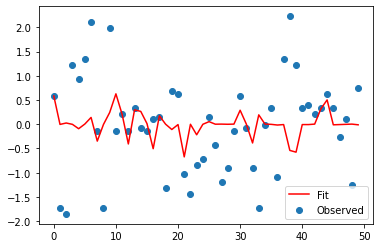

In [ ]:
def plot_observed_vs_predicted(beta_results, df, rating):
    """ Plot observed vs predicted data

    Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    beta_hats (ndarray): An array of shape (betas,) that contains the estimate of the slope parameter(s)

    """
    est_rating = (beta_results[0] + (beta_results[1]*df['CR']) + (beta_results[2]*df['EV']) + (beta_results[3]*df['RPE']) + (beta_results[4]*df['pwrd']))
    est_rating = est_rating[::3]
    
    fig, ax = plt.subplots()
    ax.scatter(range(0,50), rating, label='Observed')  # our data scatter plot
    ax.plot(range(0,50), est_rating, color='r', label='Fit')  # our estimated model

    # plot residuals
    #ymin = np.minimum(rating, est_rating)
    #ymax = np.maximum(rating, est_rating)
    #ax.vlines(range(0,50), ymin, ymax, 'g', alpha=0.5, label='Residuals')

    #ax.set(
     #   title=fr"$intercept={beta_hats[0]:0.2f}, \hat{{\beta}}$ = {beta_hats[1]:0.2f}, MSE = {MSE_val:.2f}",
      #  xlabel='x',
       # ylabel='y')
    
    ax.legend()
    plt.show()

beta_results = pwrd_results.x
plot_observed_vs_predicted(beta_results, df, rating)

The PWRD model fit does not accurately capture subject's mood ratings throughout the Subjective Wellbeing Task. 

### Discussion

Future directions will investigate whether the PWRD itself would be a good predictor of mood rating without inclusion of certain reward, gamble expected value, and reward prediction error parameters. 

My previous work indicates that counterfactual prediction errors have a strong influence on subject's mood rating. Future analyses will compute raw counterfactual signals rather than the policy-weighted reward difference. 

### References:
[1] Bennett, D. et al (2022). A Model of Mood as Integrated Advantage. Psychological Review, 129(3), 513-541. 

[2] Charpentier, C.J. et al (2017). Enhanced Risk Aversion, But Not Loss Aversion, in Unmedicated Pathological Anxiety. Biological Psychiatry, 81(12), 1014-1022. 

[3] Rutledge, R. B., et al (2014). A computational and neural model of momentary subjective well-being. Proceedings of the National Academy of Sciences, 111(33), 12252–12257. 